# Investigate what fraction of a metatranscriptome is left over after subtracting a metagenome using k-mers

This notebook performs summary statistics and visualization on the fraction of k-mers that were left in a metatranscriptome after subtracting its paired metagenome.

These values were estimated by using FracMinHash sketching. 
[FracMinhash sketches](https://www.biorxiv.org/content/10.1101/2022.01.11.475838v2.abstract) represent a fraction of the k-mers in the original sequence.

K-mers are words of length _k_ in nucleotide sequences.
Here we used k-mer sizes 21, 31, and 51 because these can be used to estimate genus, species, and strain-level similarity respectively between sets of sequences.

We also downsampled to 1/200th (0.5%) of all k-mers to facilitate faster comparisons (`scaled = 200`).
Importantly, the same fraction of k-mers is retained across samples if the same sequences are contained within those samples.
Within the sourmash ecosystem, scaled values of 1000 and 2000 are the most standard because these values are a nice compromise for speed of comparisons while retaining enough k-mers to accurately represent microbial genomes.
Because viral genomes can be very small, we reduced the scaled value to 200 to retain more k-mers with the idea that even small viral genomes would still have a few representative k-mers within the sketch.
See [this issue](https://github.com/sourmash-bio/sourmash/issues/1340) for more details about how the scaled value and the k-mer size impact the number of k-mers retained for viral genomes of different sizes.

After we sketched both the metatranscriptome and the metagenome, k-mers that occurred in the metagenome were removed from its paired metatranscriptome.

To estimate the fraction of k-mers that occurred in a metatranscriptome after subtracting its paired metagenome, we calculated the number of distinct and total k-mers in the metatranscriptome, the metagenome, and the subtracted sketches.

This notebook focuses on two values:

* `n_hashes`: the number of distinct k-mers (hashes) in a sketch.
* `sum_hashes`: the number of distinct k-mers (hashes) multiplied by the abundance of those k-mers (hashes).

The metagenome and the metatranscriptome reads were _not_ adapter, quality, or k-mer trimmed prior to sketching.
Therefore, we posit that `sum_hashes` will produce better estimates as many of the distinct `n_hashes` will be from sequencing errors but these errors will be diluted in `sum_hashes`.

In [1]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)

In [2]:
setwd("..")

In [3]:
library(purrr)
library(readr)
library(dplyr, warn.conflicts = F)
library(ggplot2)
library(ggthemes)

## Read in meta-omic pairs metadata

In [4]:
metadata <- read_tsv("inputs/metadata-paired-mgx-mtx.tsv", show_col_types = F) %>%
  mutate(subtract_pair = paste0(mtx_run_accession, "-minus-", mgx_run_accession))

In [5]:
head(metadata)

sample_name,mtx_study_accession,mtx_run_accession,mgx_study_accession,mgx_run_accession,sample_type,subtract_pair
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C_2_1,PRJNA406858,SRR6032600,PRJNA406858,SRR6032602,activated_sludge,SRR6032600-minus-SRR6032602
B_2_1,PRJNA406858,SRR6032604,PRJNA406858,SRR6032601,activated_sludge,SRR6032604-minus-SRR6032601
E_2_1,PRJNA406858,SRR6032605,PRJNA406858,SRR6032603,activated_sludge,SRR6032605-minus-SRR6032603
rumen_microbiome_of_beef_cattle_101,PRJNA448333,SRR8416057,PRJNA448333,SRR8397906,cattle_rumen,SRR8416057-minus-SRR8397906
rumen_microbiome_of_beef_cattle_103,PRJNA448333,SRR8416058,PRJNA448333,SRR8404214,cattle_rumen,SRR8416058-minus-SRR8404214
rumen_microbiome_of_beef_cattle_104,PRJNA448333,SRR8416055,PRJNA448333,SRR8397905,cattle_rumen,SRR8416055-minus-SRR8397905


## Read in sketch details, parse, and join to metadata

In [6]:
sketch_describe <- Sys.glob("outputs/sourmash_sketch_describe/*csv") %>%
  map_dfr(read_csv, show_col_types = F) %>%
  mutate(run_accession = gsub(".sig", "", basename(signature_file)))

sketch_describe_mtx <- sketch_describe %>%
  filter(run_accession %in% metadata$mtx_run_accession) %>%
  select(mtx_run_accession = run_accession, ksize, mtx_n_hashes = n_hashes, mtx_sum_hashes = sum_hashes)

sketch_describe_mgx <- sketch_describe %>%
  filter(run_accession %in% metadata$mgx_run_accession) %>%
  select(mgx_run_accession = run_accession, ksize, mgx_n_hashes = n_hashes, mgx_sum_hashes = sum_hashes)

In [7]:
sketch_describe_subtract <- Sys.glob("outputs/sourmash_sketch_subtract_describe/*csv") %>%
  map_dfr(read_csv, show_col_types = F) %>%
  mutate(subtract_pair = gsub("\\-k[235]1\\.sig", "", basename(signature_file))) %>%
  select(subtract_pair, ksize, subtract_n_hashes = n_hashes, subtract_sum_hashes = sum_hashes)

In [8]:
sketch_describe_all <- metadata %>% inner_join(sketch_describe_subtract, by = "subtract_pair") %>%
  inner_join(sketch_describe_mtx, by = c("mtx_run_accession", "ksize")) %>%
  inner_join(sketch_describe_mgx, by = c("mgx_run_accession", "ksize"))

In [9]:
# calculate the fraction of the mtx left over after the mgx was subtracted
sketch_describe_all_frac <- sketch_describe_all %>%
  mutate(f_n_hashes = subtract_n_hashes / mtx_n_hashes,
         f_sum_hashes = subtract_sum_hashes / mtx_sum_hashes)

In [10]:
nrow(sketch_describe_all_frac)

[1] 3840

## Summary statistics

In [11]:
sketch_describe_all_frac %>%
  group_by(ksize) %>%
  summarize(mean_f_sum_hashes = mean(f_sum_hashes),
            sd_f_sum_hashes = sd(f_sum_hashes),
            median_f_sum_hashes = median(f_sum_hashes),
            mean_f_n_hashes = mean(f_n_hashes),
            sd_f_n_hashes = sd(f_n_hashes),
            median_f_n_hashes = median(f_n_hashes))

ksize,mean_f_sum_hashes,sd_f_sum_hashes,median_f_sum_hashes,mean_f_n_hashes,sd_f_n_hashes,median_f_n_hashes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21,0.2185223,0.1997750,0.1389775,0.6097056,0.1765553,0.5548448
31,0.2588739,0.2082160,0.1761773,0.6645155,0.1614020,0.6228187
51,0.3041814,0.2136651,0.2193517,0.7274665,0.1410061,0.7035764


In [12]:
sketch_describe_all_frac %>%
  filter(ksize == 31) %>%
  group_by(sample_type) %>%
  summarize(mean_f_sum_hashes = mean(f_sum_hashes),
            sd_f_sum_hashes = sd(f_sum_hashes),
            median_f_sum_hashes = median(f_sum_hashes),
            mean_f_n_hashes = mean(f_n_hashes),
            sd_f_n_hashes = sd(f_n_hashes),
            median_f_n_hashes = median(f_n_hashes)) %>%
  arrange(mean_f_sum_hashes)

sample_type,mean_f_sum_hashes,sd_f_sum_hashes,median_f_sum_hashes,mean_f_n_hashes,sd_f_n_hashes,median_f_n_hashes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cocoa_box_fermentation,0.08231842,0.005502553,0.08044515,0.9388002,0.011726053,0.9434768
snail_gut,0.10001925,0.021767706,0.10598555,0.4829923,0.007098345,0.4821642
bioreactor,0.10575039,0.061581201,0.07090508,0.7208829,0.042719350,0.7223916
human_oral,0.12851143,0.054503809,0.11223960,0.3781912,0.087449911,0.3640708
mussel_gill,0.13647663,0.092183216,0.11051450,0.8151147,0.062855174,0.7982612
groundwater,0.13768127,0.044648135,0.13768127,0.9792255,0.011343316,0.9792255
activated_sludge,0.14460366,0.039706105,0.15657479,0.8344750,0.044526791,0.8240894
mouse_cecum,0.14826462,0.051141721,0.14081782,0.6912402,0.052783131,0.6951608
lake,0.17766603,NA,0.17766603,0.6610849,NA,0.6610849


## Visualize the results

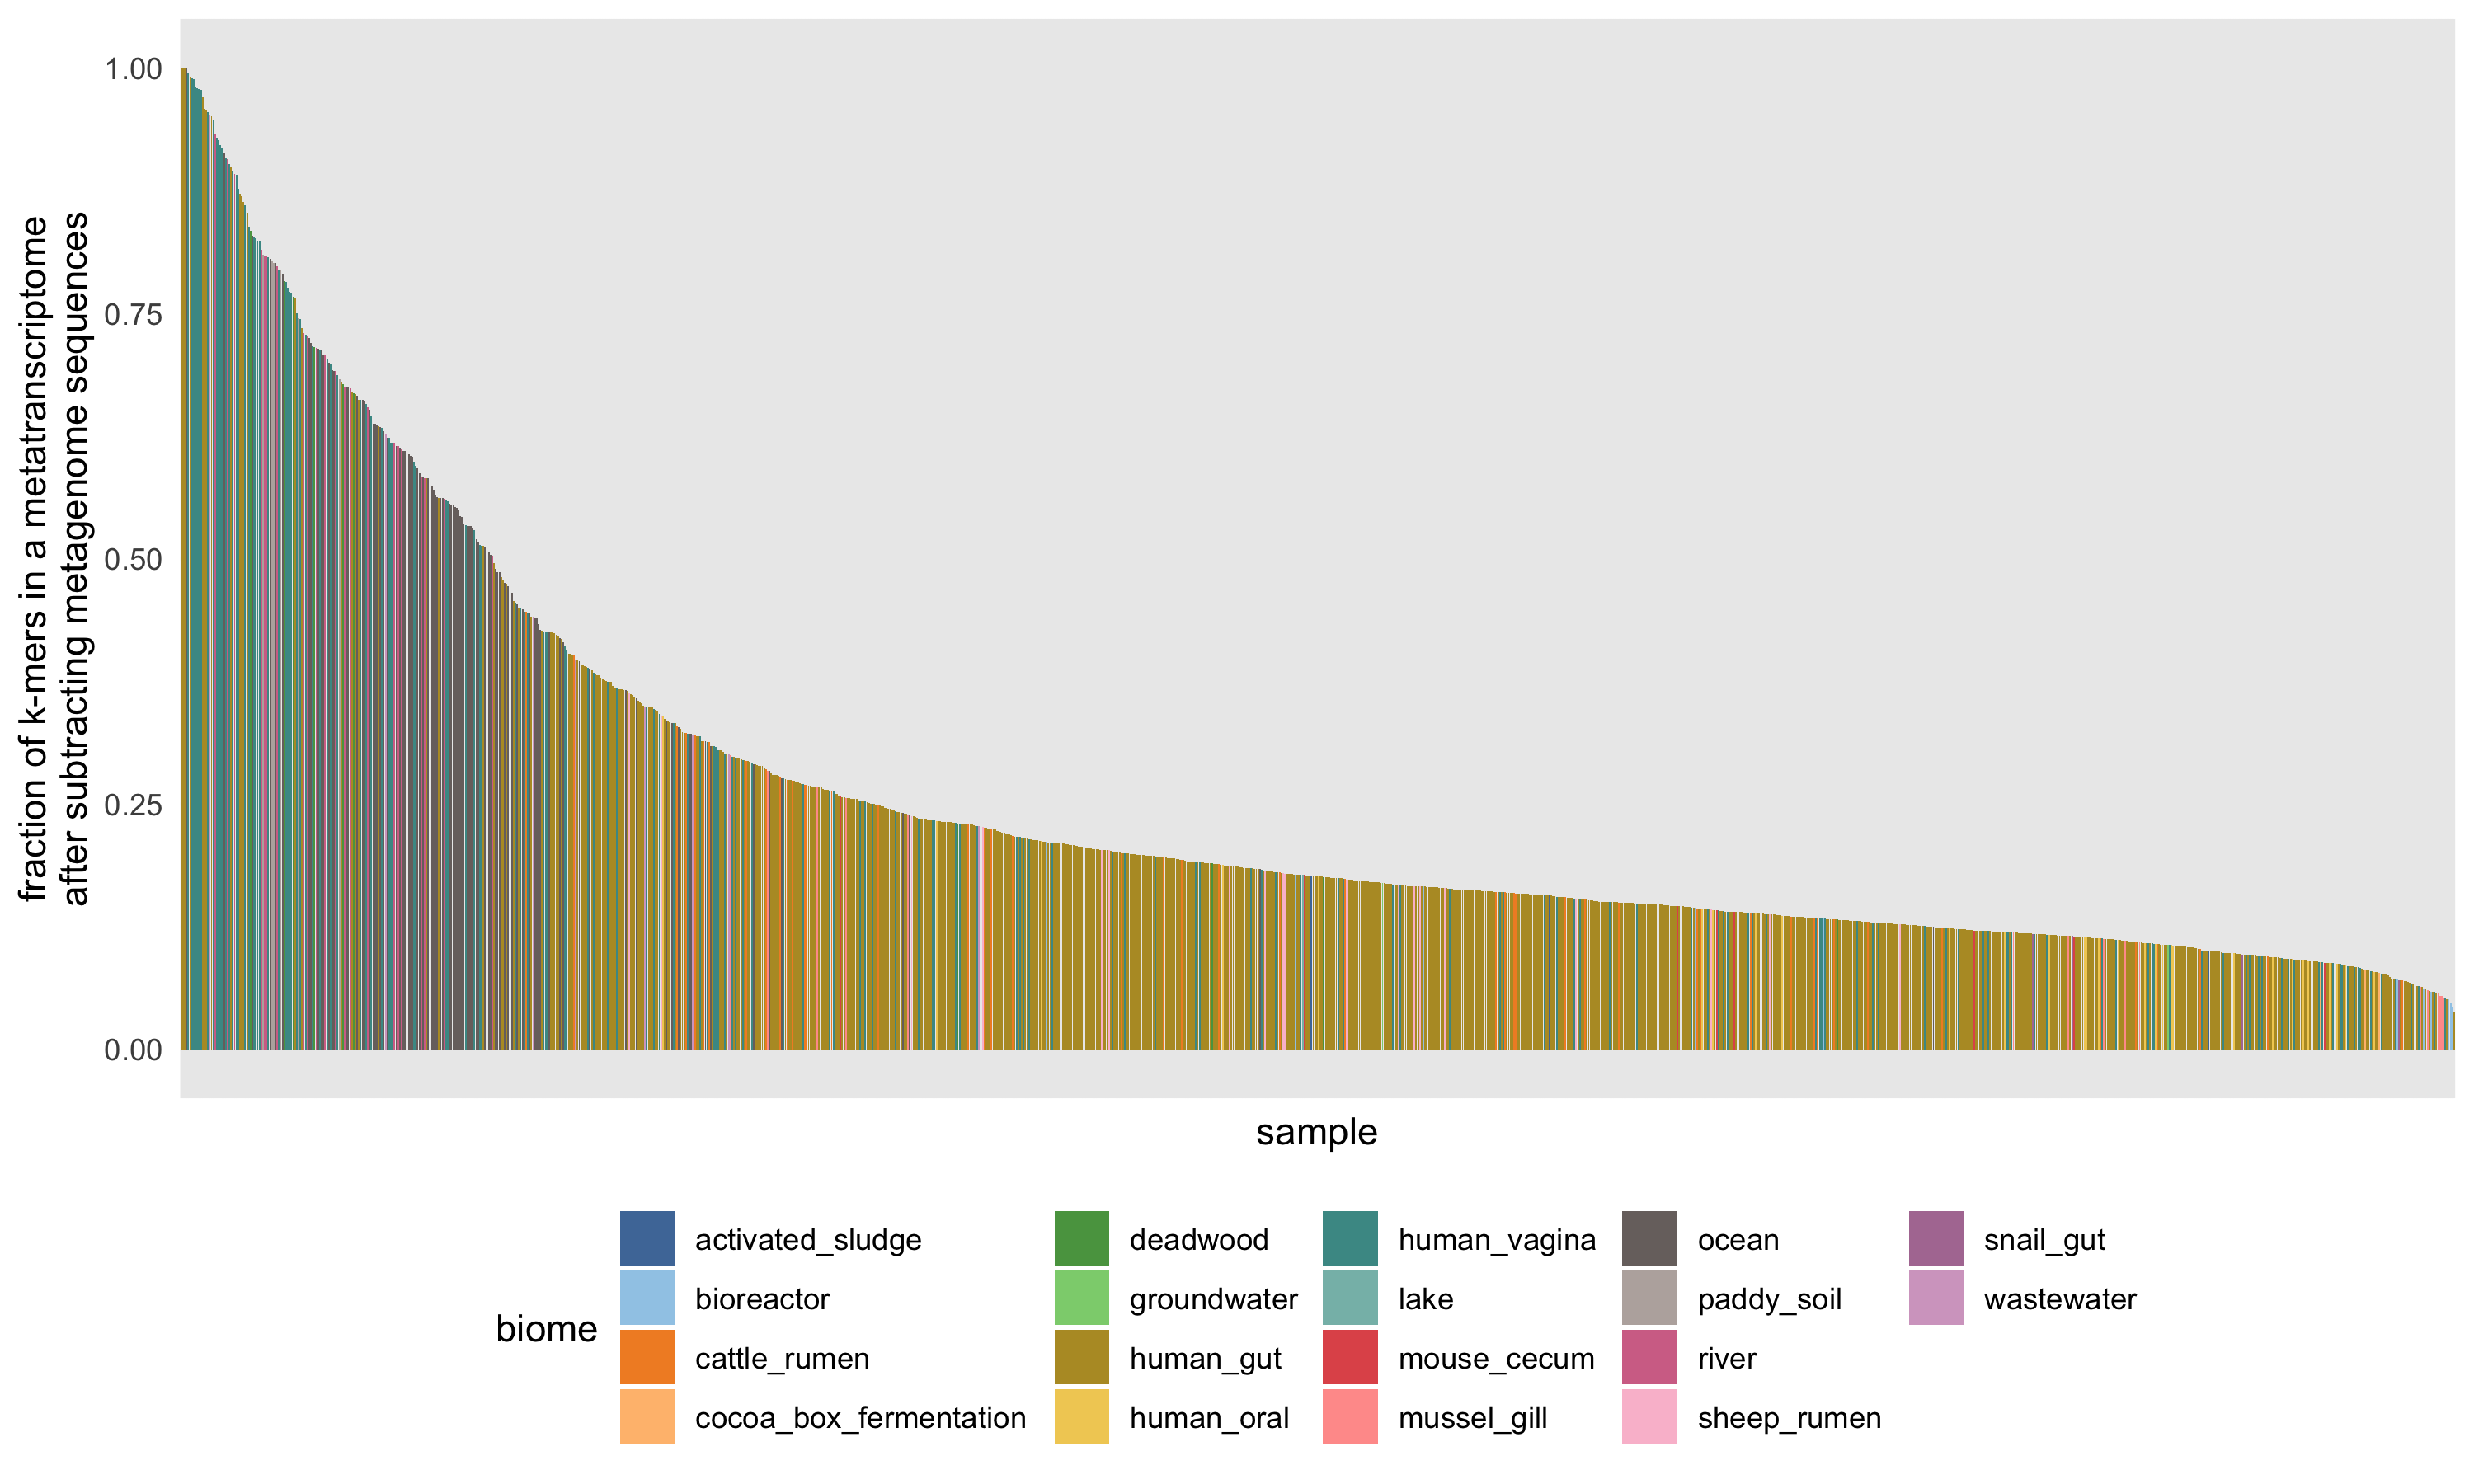

In [13]:
ggplot(sketch_describe_all_frac %>% filter(ksize == 31), 
       aes(x = reorder(sample_name, -f_sum_hashes), y = f_sum_hashes, fill = sample_type)) +
  geom_col() +
  theme_minimal() +
  theme(axis.text.x = element_blank(),
        legend.position="bottom") +
  ylim(0, 1) +
  scale_fill_tableau(palette = "Tableau 20") +
  labs(y = "fraction of k-mers in a metatranscriptome\nafter subtracting metagenome sequences", x = "sample", fill = "biome")